In [7]:
import os
import csv
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from sklearn import linear_model, metrics
import scipy.stats as st
from scipy import interpolate
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [8]:
# Changing Directory
os.chdir("A:\\WebEconomics\\dataset")


In [9]:
# Reading Data
df = pd.read_csv('validation.csv')


## Selecting Wanted Features

In [10]:
# Define our features
features = ["click", "weekday", "hour", "region", "slotwidth", 'slotheight', 'bidprice', 'payprice']
df = df[features]
df = df.dropna()

In [11]:
df['slotsize'] = df['slotwidth'] * df['slotheight'] 
df.drop(['slotwidth', 'slotheight'], axis=1, inplace=True)

In [12]:
df.head()

,click,weekday,hour,region,bidprice,payprice,slotsize
0,0,5,14,216,227,102,75000
1,0,3,14,216,277,118,16000
2,0,1,13,146,241,77,90000
3,0,5,18,146,241,77,90000
4,0,5,14,275,300,178,94080


## Labeling and Categorising Data

Categorising:
- Hour: 
    - 0:00~07:59 : 1
    - 08:00~15:59: 2
    - 16:00~23:59: 3
- Size:
    - 0~40000     : 1
    - 40000~80000 : 2
    - 80000~120000: 3

In [13]:
df['hour'] = pd.cut(df['hour'], bins = [0,8,16,23.5], right=False, labels=[1,2,3])
df['slotsize'] = pd.cut(df['slotsize'], bins = [0,40000,80000,120000], right=True, labels=[1,2,3])
df.head()  

,click,weekday,hour,region,bidprice,payprice,slotsize
0,0,5,2,216,227,102,2
1,0,3,2,216,277,118,1
2,0,1,2,146,241,77,3
3,0,5,3,146,241,77,3
4,0,5,2,275,300,178,3


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299749 entries, 0 to 299748
Data columns (total 7 columns):
click       299749 non-null int64
weekday     299749 non-null int64
hour        299749 non-null category
region      299749 non-null int64
bidprice    299749 non-null int64
payprice    299749 non-null int64
slotsize    299745 non-null category
dtypes: category(2), int64(5)
memory usage: 14.3 MB


In [15]:
df = df.dropna()
df.isnull().any().any()

False

### Dummy Coding

Since all of the variables are categorical integers, we need to convert these numbers into categorical type. To do this, we can use dummy coding. 

We will use [**``sklearn.preprocessing.LabelEncoder()``**](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder)


Encode labels with value between 0 and n_classes-1.

In [16]:
from sklearn import preprocessing

# Set the random seed
np.random.seed(12)

# Initialize label encoder
label_encoder = preprocessing.LabelEncoder()

In [17]:
# Convert all the features to numeric values
df["click"] = label_encoder.fit_transform(df["click"])
df["weekday"] = label_encoder.fit_transform(df["weekday"])
df["region"] = label_encoder.fit_transform(df["region"])

df["hour"] = label_encoder.fit_transform(df["hour"])
df["slotsize"] = label_encoder.fit_transform(df["slotsize"])

## Training Logistic Regression (linear_model.LogisticRegression)

In [18]:
# Defining X and Y
X = df[[col for col in df.columns if col not in ['click', 'payprice', 'bidprice']]]
Y = df['click']

In [19]:
# Training the model
logreg = linear_model.LogisticRegression()

In [20]:
logreg.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
logreg.score(X, Y)

0.99924602578858701

In [22]:
logreg.predict(X)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [23]:
narray = logreg.predict(X)
print(narray.sum())

0


In [24]:
logreg.predict_proba(X)

array([[  9.99143972e-01,   8.56027747e-04],
       [  9.98665967e-01,   1.33403349e-03],
       [  9.99452612e-01,   5.47387869e-04],
       ..., 
       [  9.99036831e-01,   9.63168814e-04],
       [  9.99165640e-01,   8.34359965e-04],
       [  9.99061593e-01,   9.38406605e-04]])

In [28]:
probarray = logreg.predict_proba(X)
df['log_prob'] =probarray[:,1]

In [30]:
f = interpolate.interp1d( [min(df['log_prob']) , max(df['log_prob'])], [min(df['payprice']), max(df['payprice']) ])
df['estimatedBidPrice'] = df['log_prob'].apply(  lambda x: f(x) )

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


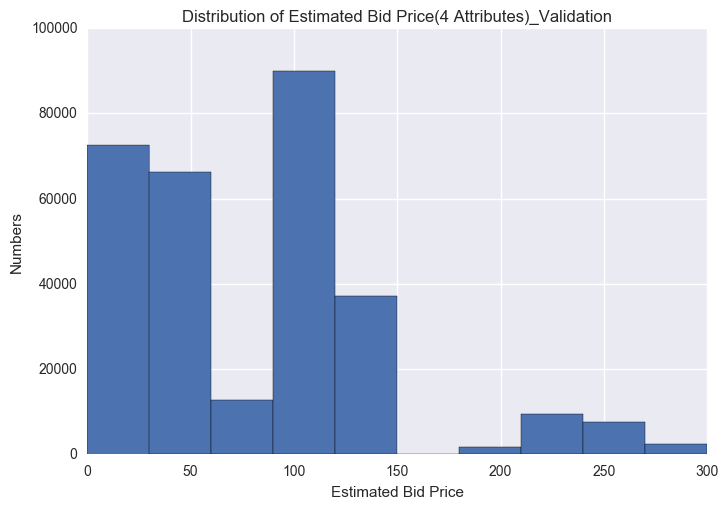

In [31]:
plt.xlabel('Estimated Bid Price')
plt.ylabel('Numbers')
df['estimatedBidPrice'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(4 Attributes)_Validation")
plt.legend()
plt.show()


In [32]:
# Information about pay price
print(df['estimatedBidPrice'].describe())
print("variance:", df['estimatedBidPrice'].var())
print("skewness:", st.skew(df['estimatedBidPrice'],bias=False)) 
print("kurtosis:", st.kurtosis(df['estimatedBidPrice'],bias=False)) 

count    299745.000000
mean         81.962815
std          59.968104
min           0.000000
25%          30.476126
50%          89.025407
75%         113.713553
max         300.000000
Name: estimatedBidPrice, dtype: float64
variance: 3596.1735301508065
skewness: 1.129538918258335
kurtosis: 1.2716589319009959


In [33]:
# Information about pay price
print(df['payprice'].describe())
print("variance:", df['payprice'].var())
print("skewness:", st.skew(df['payprice'],bias=False))
print("kurtosis:", st.kurtosis(df['payprice'],bias=False))

count    299745.000000
mean         80.217765
std          62.365778
min           0.000000
25%          33.000000
50%          70.000000
75%         101.000000
max         300.000000
Name: payprice, dtype: float64
variance: 3889.490303729888
skewness: 1.2558899702835147
kurtosis: 1.0928950971859432


C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


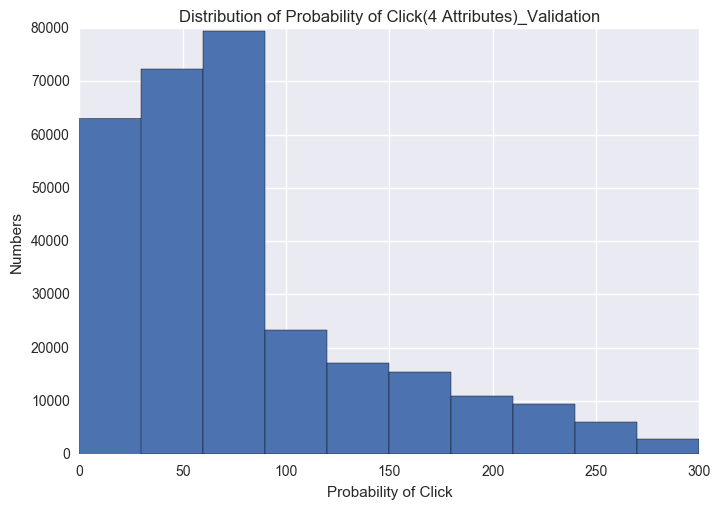

In [34]:
plt.xlabel('Probability of Click')
plt.ylabel('Numbers')
df['payprice'].hist()
#plt.yscale('log')
plt.title("Distribution of Probability of Click(4 Attributes)_Validation")
plt.legend()
plt.show()


In [35]:
f = interpolate.interp1d( [min(df['log_prob']) , max(df['log_prob'])], [min(df['payprice']), max(df['payprice']) ])
df['estimatedBidPrice_x2.5'] = df['log_prob'].apply(  lambda x: f(x)*2.5 )

C:\Users\user\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


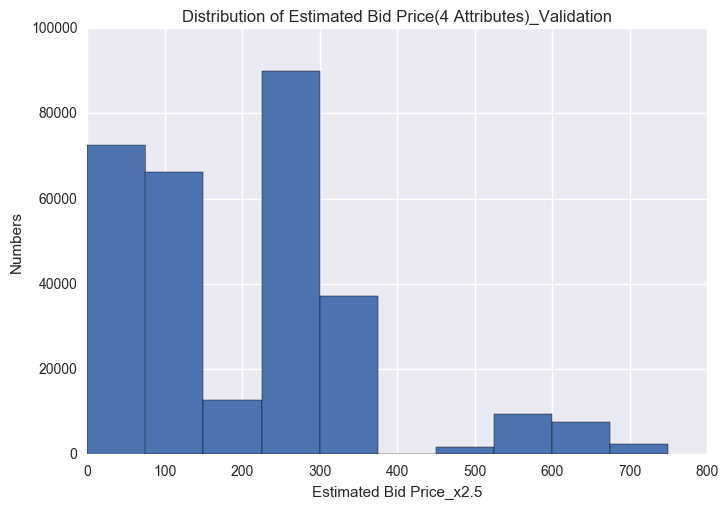

In [36]:
plt.xlabel('Estimated Bid Price_x2.5')
plt.ylabel('Numbers')
df['estimatedBidPrice_x2.5'].hist()
#plt.yscale('log')
plt.title("Distribution of Estimated Bid Price(4 Attributes)_Validation")
plt.legend()
plt.show()


## LR

#### Original

In [37]:
impression = df[df['estimatedBidPrice'] > df['payprice']]
click = impression[impression['click'] == 1 ]

impression_x2 = df[df['estimatedBidPrice_x2.5'] > df['payprice']]
click_x2 = impression_x2[impression_x2['click'] == 1 ]

In [41]:
x = PrettyTable(["Variable", "Impression", 'Click', 'CTR'])
x.align["Impression"] = "1" # Left align city names 
x.padding_width = 0 # One space between column edges and contents (default)

x.add_row(["estimatedBidPrice", impression.shape[0], \
           click.shape[0], \
           click.shape[0]/impression.shape[0]])

x.add_row(["estimatedBidPrice_x2.5", impression_x2.shape[0], \
           click_x2.shape[0], \
           click_x2.shape[0]/impression_x2.shape[0]])


print(x)

+----------------------+----------+-----+---------------------+
|       Variable       |Impression|Click|         CTR         |
+----------------------+----------+-----+---------------------+
|  estimatedBidPrice   |  141032  |  90 |0.0006381530432809575|
|estimatedBidPrice_x2.5|  239677  | 168 |0.0007009433529291505|
+----------------------+----------+-----+---------------------+
